<a href="https://colab.research.google.com/github/tdushio/hello-world/blob/master/sample20230618c_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


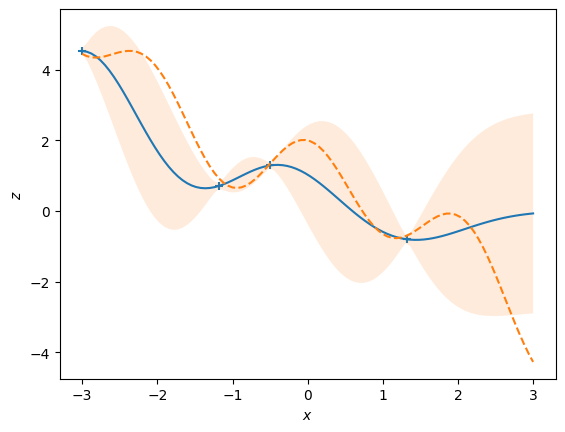

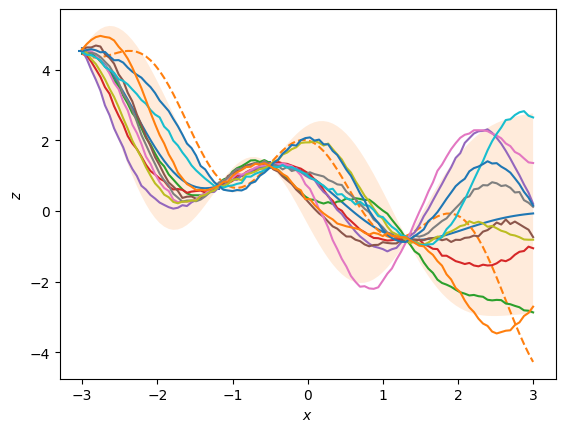

(Text(0.5, 24.0, '$x$'), Text(24.000000000000007, 0.5, '$z$'), None)

In [ ]:
# 実践１０　ガウス過程回帰による2変数関数予測　テキストp69-
import matplotlib.pyplot as plt, numpy as np, math

# 2変数関数 y の定義
def true_func(x):
  y = np.exp(-np.sum((x-np.array([-1.2,1.2]))**2,1)) \
      + np.exp(-np.sum((x-np.array([-1.2,1.2]))**2,1))
  return y


np.random.seed(1)
x = np.linspace(-3,3,100)
y = true_func(x)

# カーネル関数と行列 K の定義
def kernel_func(x1, x2,i,j,hp):
  if i == j and all(x1==x2):
    k = hp[0]**2 + hp[2]**2
  else:
    k = hp[0]**2*math.exp(-(1/(2*hp[1]**2))*np.sum((x1-x2)**2))
  return k

def kernel_matrix(x1, x2, hyperparam):
  K = np.empty((len(x1), len(x2)))
  for i in range(len(x1)):
    for j in range(len(x2)):
      K[i,j]=kernel_func(x1[i],x2[j],i,j,hyperparam)
  return K

# 訓練データの生成
n = 4
x_data = 6*np.random.rand(n) - 3
z_data = true_func(x_data) + np.random.normal(0,0.1,n)

# ハイパーパラメータの学習
!pip install GPy
import GPy

kernel = GPy.kern.RBF(1)
model = GPy.models.GPRegression(x_data.reshape(-1,1), z_data.reshape(-1,1), kernel=kernel)

hparam_priors = 3*[None]
hparam_priors[0] = GPy.priors.Gaussian(mu=0, sigma=1)
hparam_priors[1] = GPy.priors.Gaussian(mu=0, sigma=1)
hparam_priors[2] = GPy.priors.Gaussian(mu=0, sigma=0.001)
param_name = model.parameter_names()
for i in range(3):
  hparam_priors[i].domain = "positive"
  model[param_name[i]].set_prior(hparam_priors[i])

model.optimize(messages=False, optimizer='scg', max_iters=1e5)

# z(x*) の平均と分散の計算と描画
sigma_f = np.sqrt(model.rbf.variance[0])
q = model.rbf.lengthscale[0]
sigma_n = np.sqrt(model.Gaussian_noise.variance[0])
hyperparam = [sigma_f, q, sigma_n]

x, x_data = x.reshape(-1,1), x_data.reshape(-1,1)
K_ss = kernel_matrix(x, x,hyperparam)
K = kernel_matrix(x_data, x_data, hyperparam)
invK = np.linalg.inv(K)
k_s = kernel_matrix(x, x_data, hyperparam)

c = invK @ z_data
z_mean = k_s @ c
z_var = K_ss - k_s @ invK @ k_s.T
z_stdv = np.sqrt(np.diag(z_var))

fig, ax = plt.subplots()
ax.plot(x, z_mean), ax.plot(x, y, ls='--')
ax.scatter(x_data, z_data, marker='+')
ax.fill_between(x.flatten(), (z_mean-2*z_stdv).flatten(), (z_mean+2*z_stdv).flatten(), alpha=0.15)
plt.xlabel("$x$"), plt.ylabel('$z$'), plt.show()

# 予測分布に従うベクトルの生成と描画
z_samples = np.random.multivariate_normal(z_mean, z_var, 10).T

fig, ax = plt.subplots()
ax.plot(x, z_mean), ax.plot(x, y, ls='--')
ax.plot(x, z_samples), ax.scatter(x_data, z_data, marker='+')
ax.fill_between(x.flatten(), (z_mean-2*z_stdv).flatten(), (z_mean+2*z_stdv).flatten(), alpha=0.15)
plt.xlabel("$x$"), plt.ylabel('$z$'), plt.show()

